# 2D indentation using Argiope & Hardness



In [1]:
!cat local_settings.py.example

# LOCAL SETTINGS
# Modify as needed and rename local_settings.py
GMSH_PATH    = "gmsh"
ABAQUS_PATH  = "abaqus" 


In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import hardness as hd
import argiope as ag
import pandas as pd
import numpy as np
import os, subprocess, time, local_settings, time


mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['contour.negative_linestyle'] = 'solid'

# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass

In [2]:
ls

indentation_2D.ipynb*  local_settings.py.example*  tuut.png        _workdir/
local_settings.py*     __pycache__/                Untitled.ipynb


In [3]:
import importlib.resources
import shutil

MODULE_PATH = importlib.resources.files(ag)
workdir = "./_workdir"
shutil.copyfile(f"{MODULE_PATH}/assets/abqpostproc.py", f"{workdir}/abqpostproc.py")

'./_workdir/abqpostproc.py'

## Settings

In [4]:
# SETTINGS
workdir   = "_workdir/"
outputdir = "outputs/"
label   = "indentation_2D"

create_dir(workdir)
create_dir(workdir + outputdir)     

## Model definition

In [5]:
#-------------------------------------------------------------------------------
# MESH DEFINITIONS
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CAX3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CAX4R" 
    return mesh
    
    
def sample_material_map(mesh):
    mesh.elements["materials"] = "SAMPLE_MAT" 
    return mesh

def indenter_material_map(mesh):
    mesh.elements["materials"] = "INDENTER_MAT" 
    return mesh
    
    
parts = {
    "sample" : hd.models.Sample2D(lx = 1., ly = 1., 
                                   r1 = 2., r2 = 3., 
                                   Nx = 32, Ny = 16,
                                   Nr = 2, Nt = 64, 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = sample_material_map),
                                   
    "indenter" : hd.models.SpheroconicalIndenter2D(
                                   R = 1.,
                                   psi= 70.3, 
                                   r1 = 1., 
                                   r2 = 3., 
                                   r3 = 4., 
                                   lc1 = .05, 
                                   lc2 = .5,
                                   rigid = False,
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = indenter_material_map)}
                                   
materials = [ag.materials.Hollomon(label = "SAMPLE_MAT", strain_data_points = 100),
             ag.materials.Hollomon(label = "INDENTER_MAT", strain_data_points = 100)]

#-------------------------------------------------------------------------------
# STEP DEFINTIONS
steps = [
        hd.models.Step2D(name = "LOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "UNLOADING1",
                         control_type = "force", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "RELOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "LOADING2",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.4,
                         field_output_frequency = 99999),                                    
        hd.models.Step2D(name = "UNLOADING2",
                         control_type = "force",
                         kind = "adaptative", 
                         duration = 1., 
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999)
        ]                                                                                                  

model0 = hd.models.Indentation2D(label = label, 
                      parts = parts, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True)



In [6]:
print("1: Preprocessing ----------------------------------")
%time model0.write_input()
print("2: Processing -------------------------------------")
#%time model0.run_simulation()
print("3: Postprocessing ---------------------------------")
%time model0.postproc()
print("4: Saving model -----------------------------------")
%time model0.save(workdir + "model.pcklz")

1: Preprocessing ----------------------------------


CPU times: user 125 ms, sys: 7.17 ms, total: 132 ms
Wall time: 511 ms
2: Processing -------------------------------------
3: Postprocessing ---------------------------------
#### POST-PROCESSING "indentation_2D" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.22 from flex2-symme.univ-savoie.fr
     <4 out of 5 licenses remain available>.
  => POST-PROCESSED indentation_2D: DURATION = 2.27s >
# SIMULATION COMPLETED: EXTRACTING OUTPUTS
CPU times: user 144 ms, sys: 4.76 ms, total: 149 ms
Wall time: 2.42 s
4: Saving model -----------------------------------
CPU times: user 332 ms, sys: 1.77 ms, total: 333 ms
Wall time: 333 ms


In [7]:
model = ag.utils.load(workdir + "model.pcklz")

## Model checking

Mesh building and quality checking.

In [8]:
parts["indenter"].mesh.elements.head()

conn                        materials         sets        \
          n0   n1     n2     n3               ALL_ELEMENTS   all   
                                                                   
element                                                            
79       478  479  466.0  482.0  INDENTER_MAT         True  True   
80       458  442  466.0  479.0  INDENTER_MAT         True  True   
81       379  422  446.0  409.0  INDENTER_MAT         True  True   
82       346  329  315.0  297.0  INDENTER_MAT         True  True   
83        34   35  100.0   90.0  INDENTER_MAT         True  True   

                                  type        surfaces                       
        gmsh:bounding_entities argiope solver  SURFACE                       
                                                    f1     f2     f3     f4  
element                                                                      
79                       False   quad4  CAX4R    False  False  False  False  
80                       False   quad4  CAX4R    False  False  False  False  
81                       False   quad4  CAX4R    False  False  False  False  
82                       False   quad4  CAX4R    False  False  False  False  
83                       False   quad4  CAX4R     True  False  False  False

In [9]:
parts["sample"].mesh.elements.head()

conn                      materials  sets                      \
          n0   n1     n2     n3              CORE SHELL1 SHELL2   all   
                                                                        
element                                                                 
161        1    9  273.0  100.0  SAMPLE_MAT  True  False  False  True   
162      100  273  274.0   99.0  SAMPLE_MAT  True  False  False  True   
163       99  274  275.0   98.0  SAMPLE_MAT  True  False  False  True   
164       98  275  276.0   97.0  SAMPLE_MAT  True  False  False  True   
165       97  276  277.0   96.0  SAMPLE_MAT  True  False  False  True   

                                  type                sets surfaces         \
        gmsh:bounding_entities argiope solver ALL_ELEMENTS  SURFACE          
                                                                 f1     f2   
element                                                                      
161                      False   quad4  CAX4R         True    False  False   
162                      False   quad4  CAX4R         True    False  False   
163                      False   quad4  CAX4R         True    False  False   
164                      False   quad4  CAX4R         True    False  False   
165                      False   quad4  CAX4R         True    False  False   

                      
                      
            f3    f4  
element               
161      False  True  
162      False  True  
163      False  True  
164      False  True  
165      False  True

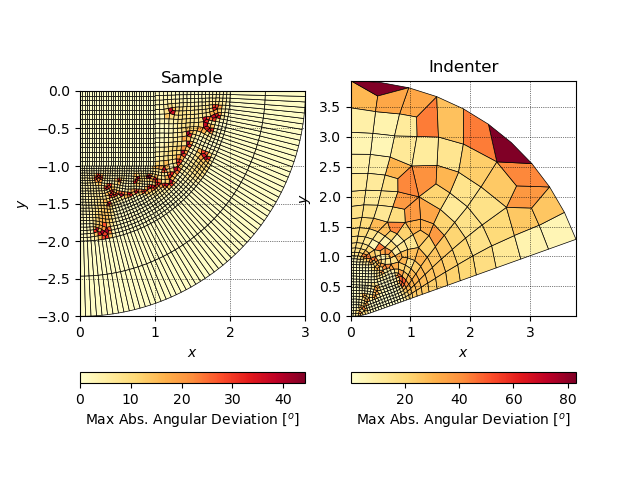

In [10]:
i = 1
fig = plt.figure()
parts_names = parts.keys()
for name, part in parts.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 2, i)
    ax.set_aspect("equal")
    ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.add_collection(patches)
    cbar = plt.colorbar(patches, orientation = "horizontal")
    cbar.set_label("Max Abs. Angular Deviation [$^o$]")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.grid()
    plt.title(name.title())
    i+= 1
plt.show()


## Simulation

## Post-Processing

### Time data


In [11]:
hist = model.data["history"]
hist.head()

time step     force   disp                          energies                \
                     F   htot     hsamp      hind          Etot          Eint   
0  0.00    0 -0.000000 -0.000 -0.000000  0.000000  0.000000e+00  0.000000e+00   
1  0.02    0  0.000171  0.004  0.001555  0.002445 -2.641008e-11  2.452619e-07   
2  0.04    0  0.000489  0.008  0.003296  0.004704 -2.630522e-09  1.484985e-06   
3  0.06    0  0.000872  0.012  0.004570  0.007430 -9.821936e-09  4.109147e-06   
4  0.08    0  0.001333  0.016  0.006747  0.009253 -2.418329e-08  8.504656e-06   

                                                    contact            \
           Wext          Wart Wfric          Wels  Aw_carea  rc_lower   
0  0.000000e+00  0.000000e+00   0.0  0.000000e+00  0.000000  0.000000   
1  3.428282e-07  1.914865e-10   0.0  1.231856e-07  0.019347  0.062283   
2  1.664063e-06  5.111062e-10   0.0  6.794270e-07  0.037618  0.093348   
3  4.386424e-06  3.932028e-09   0.0  1.734737e-06  0.062046  0.124483   
4  8.796249e-06  3.952203e-09   0.0  3.415951e-06  0.061791  0.124105   

                                                     
   rc_upper    rc_mid  zc_lower  zc_upper    zc_mid  
0  0.031250  0.015625  0.000000  0.000000  0.000000  
1  0.093604  0.077944 -0.000854 -0.000536 -0.000695  
2  0.124706  0.109027 -0.001614 -0.001143 -0.001379  
3  0.155896  0.140190 -0.002071 -0.001571 -0.001821  
4  0.155645  0.139875 -0.004177 -0.002181 -0.003179

In [12]:
hist.iloc[40:80]

time step     force      disp                      energies            \
                      F      htot     hsamp      hind      Etot      Eint   
40  0.80    0  0.032277  0.160000  0.073705  0.086295 -0.000007  0.002103   
41  0.82    0  0.033538  0.164000  0.075400  0.088600 -0.000007  0.002234   
42  0.84    0  0.034669  0.168000  0.077126  0.090874 -0.000007  0.002370   
43  0.86    0  0.036129  0.172000  0.078950  0.093050 -0.000008  0.002511   
44  0.88    0  0.037495  0.176000  0.080793  0.095207 -0.000008  0.002658   
45  0.90    0  0.038714  0.180000  0.082677  0.097323 -0.000009  0.002810   
46  0.92    0  0.040047  0.184000  0.084559  0.099441 -0.000009  0.002966   
47  0.94    0  0.041589  0.188000  0.086393  0.101607 -0.000010  0.003129   
48  0.96    0  0.042965  0.192000  0.088267  0.103733 -0.000010  0.003298   
49  0.98    0  0.044536  0.196000  0.090002  0.105998 -0.000011  0.003472   
50  1.00    0  0.092198  0.200000  0.091666  0.108334 -0.000011  0.003653   
51  1.00    1 -0.000000  0.200000  0.091666  0.108334 -0.000011  0.003653   
52  1.02    1  0.045177  0.198903  0.091177  0.107726 -0.000011  0.003603   
53  1.04    1  0.044255  0.197805  0.090688  0.107117 -0.000011  0.003554   
54  1.06    1  0.043333  0.196708  0.090199  0.106509 -0.000010  0.003506   
55  1.08    1  0.042411  0.195611  0.089710  0.105901 -0.000010  0.003460   
56  1.10    1  0.041489  0.194513  0.089221  0.105293 -0.000010  0.003414   
57  1.12    1  0.040567  0.193416  0.088731  0.104684 -0.000010  0.003369   
58  1.14    1  0.039645  0.192318  0.088242  0.104076 -0.000009  0.003325   
59  1.16    1  0.038723  0.191194  0.087736  0.103458 -0.000009  0.003281   
60  1.18    1  0.037801  0.190033  0.087207  0.102826 -0.000009  0.003237   
61  1.20    1  0.036879  0.188873  0.086679  0.102194 -0.000009  0.003194   
62  1.22    1  0.035957  0.187713  0.086151  0.101562 -0.000008  0.003152   
63  1.24    1  0.035035  0.186553  0.085623  0.100930 -0.000008  0.003111   
64  1.26    1  0.034113  0.185393  0.085095  0.100298 -0.000008  0.003071   
65  1.28    1  0.033191  0.184233  0.084567  0.099665 -0.000008  0.003033   
66  1.30    1  0.032269  0.183073  0.084040  0.099033 -0.000007  0.002995   
67  1.32    1  0.031347  0.181914  0.083513  0.098401 -0.000007  0.002958   
68  1.34    1  0.030425  0.180734  0.082976  0.097758 -0.000007  0.002922   
69  1.36    1  0.029503  0.179492  0.082407  0.097085 -0.000007  0.002885   
70  1.38    1  0.028581  0.178250  0.081840  0.096410 -0.000007  0.002849   
71  1.40    1  0.027659  0.177009  0.081272  0.095736 -0.000007  0.002814   
72  1.42    1  0.026737  0.175768  0.080706  0.095063 -0.000006  0.002781   
73  1.44    1  0.025815  0.174528  0.080140  0.094388 -0.000006  0.002748   
74  1.46    1  0.024893  0.173288  0.079574  0.093714 -0.000006  0.002717   
75  1.48    1  0.023971  0.172049  0.079008  0.093040 -0.000006  0.002687   
76  1.50    1  0.023049  0.170809  0.078444  0.092366 -0.000006  0.002658   
77  1.52    1  0.022127  0.169512  0.077860  0.091652 -0.000006  0.002629   
78  1.54    1  0.021205  0.168188  0.077268  0.090920 -0.000006  0.002600   
79  1.56    1  0.020284  0.166863  0.076675  0.090188 -0.000006  0.002573   

                                             contact                      \
        Wext          Wart Wfric      Wels  Aw_carea  rc_lower  rc_upper   
40  0.002111  5.921160e-08   0.0  0.000501  0.947952  0.530276  0.562170   
41  0.002243  4.640797e-08   0.0  0.000530  0.947510  0.530222  0.561889   
42  0.002379  6.769113e-08   0.0  0.000559  0.947164  0.530120  0.561628   
43  0.002521  5.174690e-08   0.0  0.000592  1.059678  0.561414  0.593488   
44  0.002668  4.822609e-08   0.0  0.000624  1.059270  0.561359  0.593229   
45  0.002821  7.474642e-08   0.0  0.000656  1.059131  0.561346  0.593004   
46  0.002978  9.922904e-08   0.0  0.000690  1.178490  0.592790  0.624913   
47  0.003141  1.088029e-07   0.0  0.000727  1.177728  0.592686  0.624582   
48  0.003

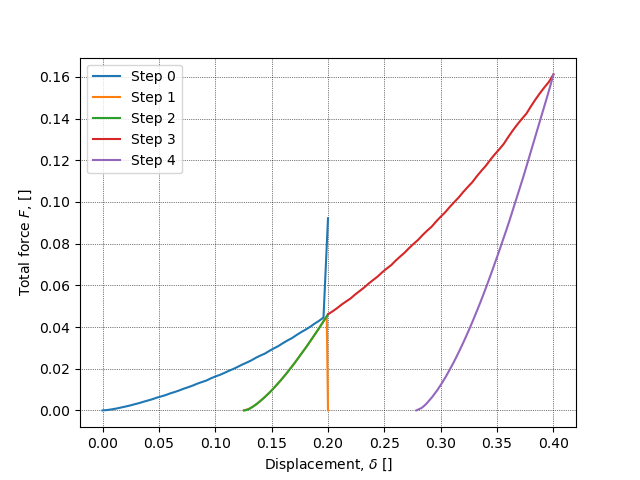

In [13]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(group.disp.htot, group.force.F, label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

### Fields

In [14]:
model.parts["sample"].mesh.fields_metadata()

,part,step_num,step_label,frame,frame_value,label,position
0,I_SAMPLE,0,LOADING1,0,0.0,S,node
1,I_SAMPLE,0,LOADING1,0,0.0,U,node
2,I_SAMPLE,0,LOADING1,1,1.0,S,node
3,I_SAMPLE,0,LOADING1,1,1.0,U,node
4,I_SAMPLE,1,UNLOADING1,0,0.0,S,node
5,I_SAMPLE,1,UNLOADING1,0,0.0,U,node
6,I_SAMPLE,1,UNLOADING1,1,1.0,S,node
7,I_SAMPLE,1,UNLOADING1,1,1.0,U,node
8,I_SAMPLE,2,RELOADING1,0,0.0,S,node
9,I_SAMPLE,2,RELOADING1,0,0.0,U,node


In [15]:
model.parts["sample"].mesh.fields_metadata()

,part,step_num,step_label,frame,frame_value,label,position
0,I_SAMPLE,0,LOADING1,0,0.0,S,node
1,I_SAMPLE,0,LOADING1,0,0.0,U,node
2,I_SAMPLE,0,LOADING1,1,1.0,S,node
3,I_SAMPLE,0,LOADING1,1,1.0,U,node
4,I_SAMPLE,1,UNLOADING1,0,0.0,S,node
5,I_SAMPLE,1,UNLOADING1,0,0.0,U,node
6,I_SAMPLE,1,UNLOADING1,1,1.0,S,node
7,I_SAMPLE,1,UNLOADING1,1,1.0,U,node
8,I_SAMPLE,2,RELOADING1,0,0.0,S,node
9,I_SAMPLE,2,RELOADING1,0,0.0,U,node


Text(0, 0.5, '$y$')

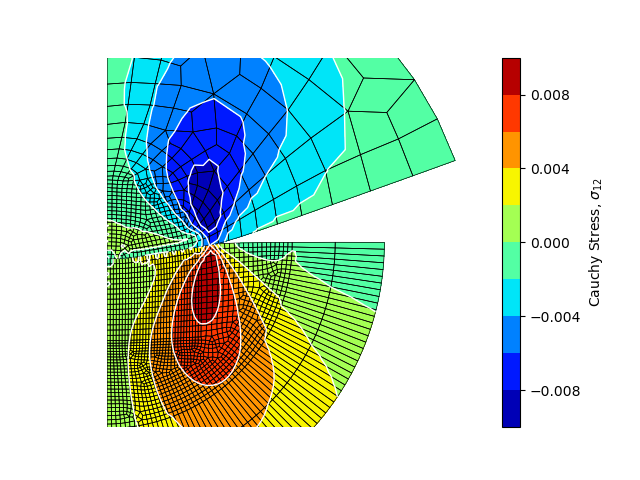

In [16]:
parts = {k:part.mesh.copy() for k, part in model.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
ax.set_xlim(0., 4.)
ax.set_ylim(-2., 2.)

field_num = 14 
disp_num = 15
levels = np.linspace(-1.e-2, 1.e-2, 11)

for k, mesh in parts.items():
    field = mesh.fields[field_num].data.v12
    disp = mesh.fields[disp_num].data
    mesh.nodes[("coords", "x")] += disp.v1
    mesh.nodes[("coords", "y")] += disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .5) 
    
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.jet, alpha = 1.)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 1.)
    ax.add_collection(patches)
cbar = plt.colorbar(grad)
cbar.set_label("Cauchy Stress, $\sigma_{12}$")
ax.axis("off")
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.grid()